In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Rescaling
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os

In [17]:
# Step 1: Dataset Preparation
def prepare_dataset(data_dir, batch_size=32, img_size=(128, 128)):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
    )

    # Extract class names before normalization
    class_names = train_ds.class_names

    # Data Augmentation
    data_augmentation = Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ])

    # Normalize pixel values to [0, 1]
    normalization_layer = Rescaling(1.0 / 255)
    train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    
    return train_ds, val_ds, class_names

In [18]:
# Step 2: Build Model
def build_model(img_size=(128, 128)):
    base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights="imagenet")
    base_model.trainable = False  # Freeze the base model initially

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.6),  # Increased dropout rate to prevent overfitting
        Dense(2, activation="softmax")  # Two output classes: Cat and Dog
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [19]:
# Step 3: Plot Training History
def plot_training_history(history):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    ax[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].plot(history.history['loss'], label='Training Loss', marker='o')
    ax[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    ax[1].grid(True)
    
    plt.show()


In [20]:
from PIL import Image, ImageDraw, ImageFont

def classify_and_label_image(model, img_path, class_names, font_size=50, text_color="orange"):
    # Load and preprocess the image
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize to [0, 1]

    # Predict the class
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_name = class_names[class_idx]

    # Open the image for labeling
    img_with_label = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img_with_label)

    # Use a truetype font with adjustable size
    try:
        # Use a bold font (default to a system font path; adjust if needed)
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        # Fallback to default font if custom font isn't found
        font = ImageFont.load_default()

    # Draw the text
    text = f"Classified: {class_name}"
    draw.text((25, 25), text, fill=text_color, font=font)

    # Display the image with the label
    img_with_label.show()
    return class_name


In [21]:
# Main Workflow
if __name__ == "__main__":
    data_dir = "C:/Users/Acer/Downloads/Activity_01/dataset"  # Replace with your dataset path
    batch_size = 32
    img_size = (128, 128)

In [22]:
print("Step 1: Preparing dataset...")
train_ds, val_ds, class_names = prepare_dataset(data_dir, batch_size=batch_size, img_size=img_size)
print("Classes:", class_names)

Step 1: Preparing dataset...
Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Classes: ['cats', 'dogs']


In [23]:
print("Step 2: Building model...")
model = build_model(img_size=img_size)

Step 2: Building model...


In [24]:
print("Step 3: Training model...")
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=70, callbacks=[early_stopping])

Step 3: Training model...
Epoch 1/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 521ms/step - accuracy: 0.7282 - loss: 2.8278 - val_accuracy: 0.9510 - val_loss: 1.9803
Epoch 2/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 396ms/step - accuracy: 0.8599 - loss: 2.0672 - val_accuracy: 0.9605 - val_loss: 1.6086
Epoch 3/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 111s 441ms/step - accuracy: 0.8862 - loss: 1.7012 - val_accuracy: 0.9620 - val_loss: 1.3355
Epoch 4/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 118s 468ms/step - accuracy: 0.8908 - loss: 1.4331 - val_accuracy: 0.9620 - val_loss: 1.1299
Epoch 5/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 322ms/step - accuracy: 0.8945 - loss: 1.2352 - val_accuracy: 0.9645 - val_loss: 0.9688
Epoch 6/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 313ms/step - accuracy: 0.8994 - loss: 1.0770 - val_accuracy: 0.9625 - val_loss: 0.8381
Epoch 7/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.9032 - loss: 0.9455 - val_accuracy: 0.9635 - val_loss: 0.7302
Epoch 8/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 305ms/step

Step 4: Plotting training history...


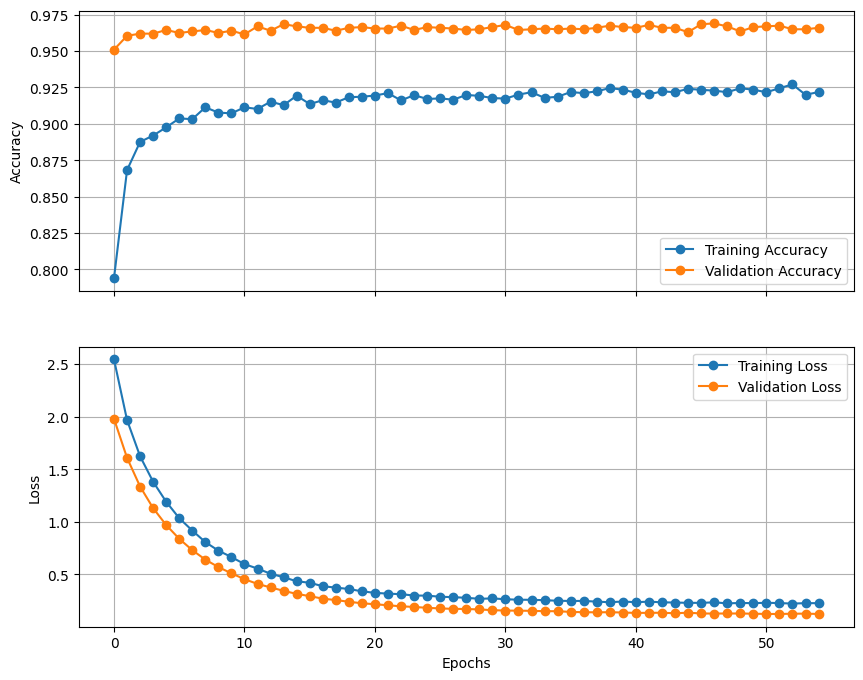

In [25]:
print("Step 4: Plotting training history...")
plot_training_history(history)

In [26]:
print("Step 5: Evaluating model...")
# Unbatch the dataset properly to extract test data and labels
X_test = []
y_test = []
for img_batch, label_batch in val_ds:
    X_test.append(img_batch.numpy())
    y_test.append(label_batch.numpy())
    
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

Step 5: Evaluating model...
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step


In [27]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

        cats       0.97      0.97      0.97       980
        dogs       0.97      0.97      0.97      1020

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

Accuracy: 0.9675


In [29]:
print("Step 6: Classifying a new image...")
test_img_path = "C:/Users/Acer/Downloads/Activity_01/photo_2024-05-14_23-47-28.jpg"  # Replace with a test image path
result = classify_and_label_image(model, test_img_path, class_names)
print(f"Classification Result: {result}")

Step 6: Classifying a new image...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Classification Result: cats


In [30]:
# Save the model
print("Step 7: Saving the model...")
save_dir = "saved_model"
os.makedirs(save_dir, exist_ok=True)
model.save(os.path.join(save_dir, "my_model.keras"))  # Save in .keras format

Step 7: Saving the model...


In [31]:
# Save training history for later visualization
np.save(os.path.join(save_dir, "history.npy"), history.history)
print(f"Model saved at {os.path.join(save_dir, 'my_model.keras')}")

Model saved at saved_model\my_model.keras


In [32]:
# Save the model in .h5 format as well
print("Step 7: Saving the model...")

# Save in .h5 format
save_dire = "saved_model_01"
os.makedirs(save_dire, exist_ok=True)

# Saving the model in .h5 format
model.save(os.path.join(save_dire, "my_model.h5"))  # Save in .h5 format
print(f"Model saved at {os.path.join(save_dire, 'my_model.h5')}")


Step 7: Saving the model...
Model saved at saved_model_01\my_model.h5
